## Observe volatility clustering

Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.

We will get familiar with the S&P 500 daily price dataset. We will calculate daily returns as the percentage price changes, plot the results and observe its behavior over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import DataReader
from datetime import datetime

                  Close    Return
Date                             
2020-06-26  3009.050049 -2.422691
2020-06-29  3053.239990  1.468568
2020-06-30  3100.290039  1.540988
2020-07-01  3115.860107  0.502213
2020-07-02  3130.010010  0.454125
2020-07-06  3179.719971  1.588173
2020-07-07  3145.320068 -1.081853
2020-07-08  3169.939941  0.782746
2020-07-09  3152.050049 -0.564361
2020-07-10  3185.040039  1.046620


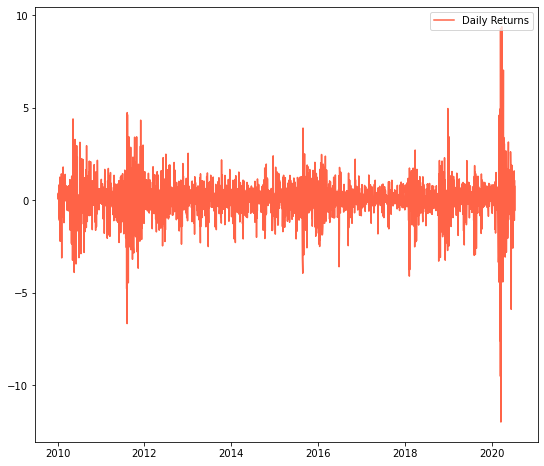

In [2]:
start = datetime(2010,1,1)
end = datetime(2020,7,10)

sp_price = DataReader('^GSPC', 'yahoo',start, end)
sp_price.drop(columns=['High','Low','Open','Volume','Adj Close'], inplace=True)
sp_price['Return'] = 100*(sp_price['Close'].pct_change())

# View the data
print(sp_price.tail(10))

# plot the data
plt.plot(sp_price['Return'], color = 'tomato', label = 'Daily Returns')
plt.legend(loc='upper right')
plt.show()

As shown in the plot, the market exhibited periods of high volatility followed by periods of low volatility.

## Calculate volatility

In [3]:
sp_price['Return'] = sp_price['Return']

# Calculate daily std of returns
std_daily = sp_price['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

Daily volatility:  1.10%
Monthly volatility:  5.06%
Annual volatility:  17.53%


## Simulate ARCH and GARCH series

The difference between an ARCH(1) and a GARCH(1,1) model is: besides an autoregressive component of α multiplying lag-1 residual squared, a GARCH model includes a moving average component of β multiplying lag-1 variance.

In [4]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

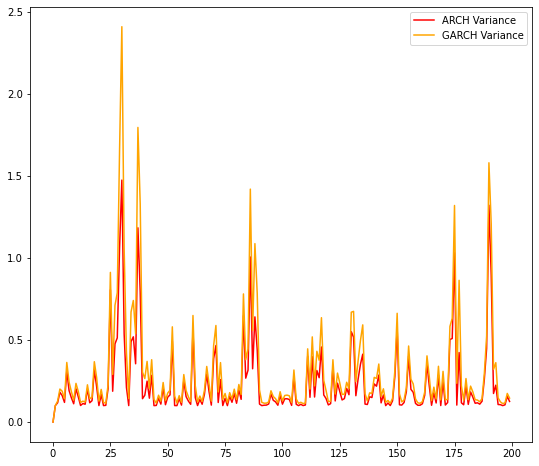

In [5]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)
# Plot the ARCH variance
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')
# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

Overall GARCH model generated higher volatility estimates due to the additional moving average component.

## Observe the impact of model parameters

Recall in GARCH(1,1), since β is the coefficient of lag-1 variance, if the α is fixed, the larger the β, the longer the duration of the impact. In other words, high or low volatility periods tend to persist.

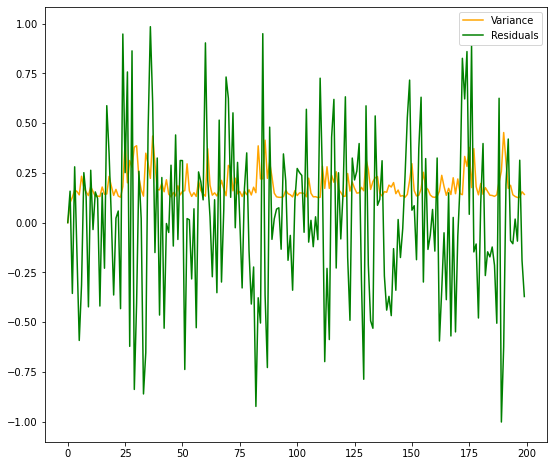

In [6]:
# First simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, 
                                          alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

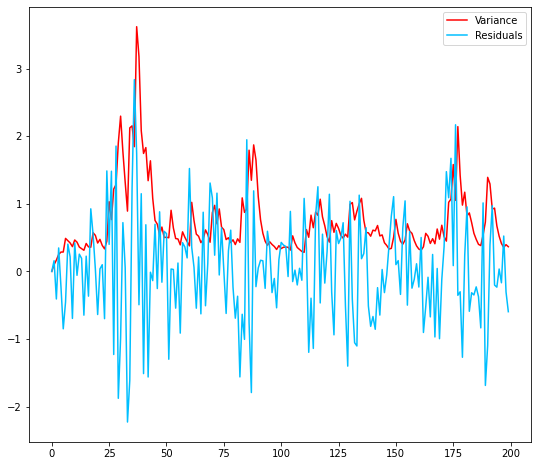

In [7]:
# Second simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, 
                                          alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

This second simulated GARCH time series has bigger variances in general. The shock that occurred earlier had persistent impact on later data points.

## Implement a basic GARCH model

Iteration:      4,   Func. Count:     37,   Neg. LLF: 3283.6519684083787
Iteration:      8,   Func. Count:     63,   Neg. LLF: 3283.2164502097353
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3283.2164105426255
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3283.22
Distribution:                  Normal   AIC:                           6574.43
Method:            Maximum Likelihood   BIC:                           6597.96
                                        No. Observations:                 2647
Date:                Sun, Jul 12 2020   Df Residuals:                     2643
Time:        

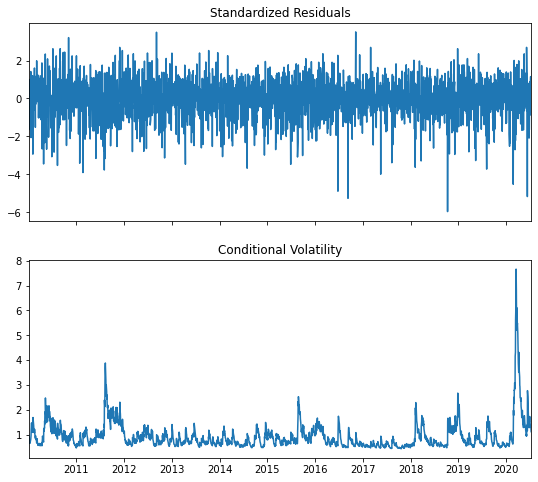

In [8]:
from arch import arch_model

# Specify GARCH model assumptions
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4,disp = 'off')

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot()
plt.show()

## Make forecast with GARCH models

In [9]:
# Specify a GARCH(1,1) model
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(disp = 'off')

# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3298.2782910866417
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3289.200092761749
Iteration:      3,   Func. Count:     29,   Neg. LLF: 3284.0539998969552
Iteration:      4,   Func. Count:     37,   Neg. LLF: 3283.6519684083787
Iteration:      5,   Func. Count:     44,   Neg. LLF: 3283.4588156379946
Iteration:      6,   Func. Count:     51,   Neg. LLF: 3283.2995920063404
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3283.217438997437
Iteration:      8,   Func. Count:     63,   Neg. LLF: 3283.2164502097353
Iteration:      9,   Func. Count:     69,   Neg. LLF: 3283.216410543364
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3283.2164105426255
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-07-10  1.1